### dataloader

- 30 fps par second en moyenne, mean=q25%=q50%=q75%=30, std = 3, max=33, min=0
- 42: taille minimale des poses consécutifs, peu importe la pose soit un peu plus d'une seconde
- 300: taille max soit 10 secondes pour nothing
- entraîner le modèle sur des séquences d'une seconde, peu importe la durée de l'action, 
padder les frames à fps max s'il faut, en mettant tous les n=features à 0, et prédire un label pour chaque frame
- mettre des labels -100 sur les tokens de padding et les ignorer dans la loss
- à l'inférence, prédire à chaque frame, et afficher sur des intervalles correspondant au temps de réaction d'un humain, peut-être chaque 1/2 second selon que le modèle détecte un changement de motion

In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset

In [28]:
import os

files = os.listdir('../data/csv_files_converted')
files

['2024-11-22-14-49-58.140.csv',
 '2024-11-22-14-52-58.169.csv',
 '2024-11-22-14-55-15.913.csv',
 '2024-11-22-14-56-28.671.csv',
 '2024-11-22-14-59-17.969.csv',
 '2024-11-22-15-00-23.410.csv',
 '2024-11-22-15-01-31.563.csv',
 '2024-11-22-15-02-36.778.csv',
 '2024-11-22-15-04-28.957.csv',
 '2024-11-22-15-05-39.475.csv']

In [ ]:
actions_list = []
total_pose = 0
for file in files:
    path = f'../data/csv_files/{file}'
    df = pd.read_csv(path)
    actions_list += list(df.action.unique())
    total_pose += len(df)
total_pose

In [30]:
df = pd.read_csv(f'../data/csv_files_converted/{files[1]}')

In [52]:
fps = []
action_per_sec = []
for file in files:
    df = pd.read_csv(f'../data/csv_files/{file}')
    df.loc[df.action.isin(nothing), 'action'] = 'NOTHING'
    for i in range(int(df.relative_time.max())):
        df_second = df[(df.relative_time>=i) & (df.relative_time<i+1)]
        fps.append(len(df_second))
        if len(df_second)>0:
            action_per_sec.append({"action": df_second.action.value_counts().index[0], 
                                   "count": df_second.action.value_counts()[0],
                                   "fps": len(df_second)})

In [53]:
action_per_sec

[{'action': 'NOTHING', 'count': 13, 'fps': 13},
 {'action': 'NOTHING', 'count': 30, 'fps': 30},
 {'action': 'SHAKE', 'count': 12, 'fps': 13},
 {'action': 'SHAKE', 'count': 30, 'fps': 30},
 {'action': 'SHAKE', 'count': 30, 'fps': 30},
 {'action': 'SHAKE', 'count': 23, 'fps': 23},
 {'action': 'NOTHING', 'count': 12, 'fps': 22},
 {'action': 'JUMP', 'count': 30, 'fps': 30},
 {'action': 'NOTHING', 'count': 12, 'fps': 30},
 {'action': 'ACTIVATE', 'count': 30, 'fps': 30},
 {'action': 'ACTIVATE', 'count': 30, 'fps': 30},
 {'action': 'NOTHING', 'count': 30, 'fps': 30},
 {'action': 'NOTHING', 'count': 30, 'fps': 30},
 {'action': 'NOTHING', 'count': 33, 'fps': 33},
 {'action': 'NOTHING', 'count': 30, 'fps': 30},
 {'action': 'NOTHING', 'count': 30, 'fps': 30},
 {'action': 'NOTHING', 'count': 30, 'fps': 30},
 {'action': 'NOTHING', 'count': 27, 'fps': 30},
 {'action': 'JUMP', 'count': 30, 'fps': 30},
 {'action': 'NOTHING', 'count': 12, 'fps': 33},
 {'action': 'SHAKE', 'count': 30, 'fps': 30},
 {'act

In [ ]:
pd.DataFrame(fps).describe()

,0
count,549.000000
mean,30.029144
std,2.928445
min,0.000000
25%,30.000000
50%,30.000000
75%,30.000000
max,33.000000


In [10]:
import numpy as np
actions_list = np.unique(actions_list)
actions_list

array(['ACTIVATE', 'CROUCH', 'IDLE', 'INFO_DISPLAYED', 'JUMP',
       'LEFT_STEP', 'RIGHT_STEP', 'SHAKE'], dtype='<U14')

In [ ]:
action = df['action']
nothing = ['IDLE', 'INFO_DISPLAYED', 'LEFT_STEP', 'RIGHT_STEP']
action[action.isin(nothing)] = 'NOTHING'
action

In [12]:
action.value_counts()

NOTHING     718
JUMP        423
CROUCH      423
ACTIVATE    273
Name: action, dtype: int64

In [14]:
from collections import defaultdict

def count_consecutive_series(sequence, labels):
    """
    Compte les séries consécutives pour chaque label et enregistre leurs tailles.
    
    sequence: Liste contenant la séquence de labels.
    labels: Liste des labels possibles.
    
    Returns:
        Un dictionnaire où chaque clé est un label et la valeur est une liste des tailles des séries.
    """
    # Initialisation du dictionnaire pour stocker les tailles des séries
    series_counts = defaultdict(list)

    # Variables pour suivre la série actuelle
    current_label = None
    current_count = 0

    for label in sequence:
        if label == current_label:
            # Si le label est identique au précédent, on incrémente le compteur
            current_count += 1
        else:
            # Si le label change, on enregistre la série précédente
            if current_label is not None:
                series_counts[current_label].append(current_count)
            # Mettre à jour le label actuel et réinitialiser le compteur
            current_label = label
            current_count = 1

    # Ajouter la dernière série
    if current_label is not None:
        series_counts[current_label].append(current_count)

    # Assurer que tous les labels apparaissent dans le dictionnaire
    for label in labels:
        if label not in series_counts:
            series_counts[label] = []

    return series_counts

In [ ]:
all_series_counts = {x: [] for x in ['ACTIVATE', 'CROUCH', 'NOTHING', 'JUMP', 'SHAKE']}
for file in files:
    path = f'../data/csv_files/{file}'
    df = pd.read_csv(path)

    action = df['action']
    action[action.isin(nothing)] = 'NOTHING'
    series_counts = count_consecutive_series(action, ['ACTIVATE', 'CROUCH', 'NOTHING', 'JUMP', 'SHAKE'])
    
    for key in all_series_counts:
        if key in series_counts:
            all_series_counts[key] = all_series_counts[key] + series_counts[key]

(array([88.,  2., 13., 10.,  4., 11.,  5.,  1.,  1.,  3.]),
 array([  1.,  33.,  65.,  97., 129., 161., 193., 225., 257., 289., 321.]),
 <BarContainer object of 10 artists>)

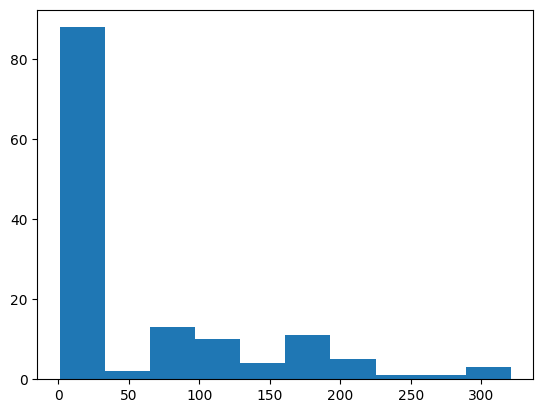

In [54]:
import matplotlib.pyplot as plt

plt.hist(all_series_counts['NOTHING'])

In [61]:
actions2labels = {'ACTIVATE':1, 
 'CROUCH':2, 
 'IDLE':0, # nothing
 'INFO_DISPLAYED':0, 
 'JUMP':3,
 'LEFT_STEP':0, 
 'RIGHT_STEP':0, 
 'SHAKE': 4}

def convert_frame_csv(df):
    
    def split_tuple_column(col):
        return col.apply(lambda x: tuple(map(float, x.strip("()").split(','))))

    df_ = pd.DataFrame(df['relative_time'])
    # Transformer le DataFrame
    for col in df.columns[1:-1]:
        # Convertir les chaînes en tuples
        tuples = split_tuple_column(df[col])
        
        # Créer les nouvelles colonnes pour x, y, z, p
        df_[f'{col}_x'] = tuples.apply(lambda t: t[0])
        df_[f'{col}_y'] = tuples.apply(lambda t: t[1])
        df_[f'{col}_p'] = tuples.apply(lambda t: t[3])

    df_ = pd.concat([df_, df['action']], axis=1)

    return df_

In [ ]:
from tqdm import tqdm

for file in tqdm(files):
    df = pd.read_csv(f'../data/csv_files/{file}')
    df = convert_frame_csv(df)
    df['action_code'] = 0
    for action in df.action.unique():
        df.loc[df.action == action, 'action_code'] = actions2labels[action]
    
    df.drop(['action'], axis=1, inplace=True)
    df.to_csv(f'../data/csv_files_converted/{file}', index=False)

In [40]:
def split_tuple_column(col):
    return col.apply(lambda x: tuple(map(float, x.strip("()").split(','))))

df_ = pd.DataFrame(df['relative_time'])
# Transformer le DataFrame
for col in df.columns[1:-1]:
    # Convertir les chaînes en tuples
    tuples = split_tuple_column(df[col])
    
    # Créer les nouvelles colonnes pour x, y, z, p
    df_[f'{col}_x'] = tuples.apply(lambda t: t[0])
    df_[f'{col}_y'] = tuples.apply(lambda t: t[1])
    df_[f'{col}_p'] = tuples.apply(lambda t: t[3])

df_ = pd.concat([df_, df['action']], axis=1)

df_

,relative_time,NOSE_x,NOSE_y,NOSE_p,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_p,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_p,...,RIGHT_HEEL_x,RIGHT_HEEL_y,RIGHT_HEEL_p,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_p,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_p,action
0,0.000003,0.908151,0.377057,0.991300,0.907933,0.337525,0.989030,0.910916,0.334304,0.989894,...,0.917690,1.573847,0.106442,0.855478,1.598760,0.189950,0.826515,1.628760,0.062048,LEFT_STEP
1,0.000185,0.908151,0.377057,0.991300,0.907933,0.337525,0.989030,0.910916,0.334304,0.989894,...,0.917690,1.573847,0.106442,0.855478,1.598760,0.189950,0.826515,1.628760,0.062048,LEFT_STEP
2,0.000274,0.878059,0.377101,0.992086,0.881818,0.339911,0.990027,0.885482,0.337215,0.990794,...,0.851452,1.302500,0.113600,0.757849,1.355196,0.202173,0.767846,1.290459,0.065722,LEFT_STEP
3,0.056491,0.878059,0.377101,0.992086,0.881818,0.339911,0.990027,0.885482,0.337215,0.990794,...,0.851452,1.302500,0.113600,0.757849,1.355196,0.202173,0.767846,1.290459,0.065722,LEFT_STEP
4,0.056658,0.878059,0.377101,0.992086,0.881818,0.339911,0.990027,0.885482,0.337215,0.990794,...,0.851452,1.302500,0.113600,0.757849,1.355196,0.202173,0.767846,1.290459,0.065722,LEFT_STEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,9.812842,0.806147,0.440325,0.999648,0.816990,0.409700,0.999533,0.820650,0.409231,0.999476,...,0.850678,1.767658,0.008447,0.908015,1.764039,0.007685,0.839566,1.795935,0.009521,LEFT_STEP
305,9.812895,0.807728,0.437436,0.999546,0.818249,0.406794,0.999487,0.822152,0.406156,0.999401,...,0.863129,1.728501,0.007663,0.922270,1.748652,0.006942,0.850728,1.773876,0.008603,LEFT_STEP
306,9.911952,0.807728,0.437436,0.999546,0.818249,0.406794,0.999487,0.822152,0.406156,0.999401,...,0.863129,1.728501,0.007663,0.922270,1.748652,0.006942,0.850728,1.773876,0.008603,LEFT_STEP
307,9.912017,0.807728,0.437436,0.999546,0.818249,0.406794,0.999487,0.822152,0.406156,0.999401,...,0.863129,1.728501,0.007663,0.922270,1.748652,0.006942,0.850728,1.773876,0.008603,LEFT_STEP


In [41]:
# Conversion de 'action' en catégorie et codage
df_['action'] = df_['action'].astype('category')
action_code = pd.DataFrame(df_['action'].cat.codes, columns=['action_code'])
df_ = pd.concat([df_, action_code], axis=1)

# Affichage des catégories et des codes associés
categories = dict(enumerate(df_['action'].cat.categories))
print("Mapping des codes :", categories)

print("\nDataFrame transformé :")
df_.drop(['action'], axis=1, inplace=True)
df_

Mapping des codes : {0: 'LEFT_STEP'}

DataFrame transformé :


,relative_time,NOSE_x,NOSE_y,NOSE_p,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_p,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_p,...,RIGHT_HEEL_x,RIGHT_HEEL_y,RIGHT_HEEL_p,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_p,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_p,action_code
0,0.000003,0.908151,0.377057,0.991300,0.907933,0.337525,0.989030,0.910916,0.334304,0.989894,...,0.917690,1.573847,0.106442,0.855478,1.598760,0.189950,0.826515,1.628760,0.062048,0
1,0.000185,0.908151,0.377057,0.991300,0.907933,0.337525,0.989030,0.910916,0.334304,0.989894,...,0.917690,1.573847,0.106442,0.855478,1.598760,0.189950,0.826515,1.628760,0.062048,0
2,0.000274,0.878059,0.377101,0.992086,0.881818,0.339911,0.990027,0.885482,0.337215,0.990794,...,0.851452,1.302500,0.113600,0.757849,1.355196,0.202173,0.767846,1.290459,0.065722,0
3,0.056491,0.878059,0.377101,0.992086,0.881818,0.339911,0.990027,0.885482,0.337215,0.990794,...,0.851452,1.302500,0.113600,0.757849,1.355196,0.202173,0.767846,1.290459,0.065722,0
4,0.056658,0.878059,0.377101,0.992086,0.881818,0.339911,0.990027,0.885482,0.337215,0.990794,...,0.851452,1.302500,0.113600,0.757849,1.355196,0.202173,0.767846,1.290459,0.065722,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,9.812842,0.806147,0.440325,0.999648,0.816990,0.409700,0.999533,0.820650,0.409231,0.999476,...,0.850678,1.767658,0.008447,0.908015,1.764039,0.007685,0.839566,1.795935,0.009521,0
305,9.812895,0.807728,0.437436,0.999546,0.818249,0.406794,0.999487,0.822152,0.406156,0.999401,...,0.863129,1.728501,0.007663,0.922270,1.748652,0.006942,0.850728,1.773876,0.008603,0
306,9.911952,0.807728,0.437436,0.999546,0.818249,0.406794,0.999487,0.822152,0.406156,0.999401,...,0.863129,1.728501,0.007663,0.922270,1.748652,0.006942,0.850728,1.773876,0.008603,0
307,9.912017,0.807728,0.437436,0.999546,0.818249,0.406794,0.999487,0.822152,0.406156,0.999401,...,0.863129,1.728501,0.007663,0.922270,1.748652,0.006942,0.850728,1.773876,0.008603,0


In [47]:
df_.to_csv('../data/2024-11-22-11-30-11_LEFT_STEP_transformed.csv', index=False)

In [55]:
N_POSE_FEATURES = 33*3
N_MIN_POSE = 39*2
ACTION_DURATION = 39*2

class DataCollatorForPoseMoveDetection(Dataset):
    
    def __init__(self,
                df_input,
                n_min_pose = N_MIN_POSE,
                action_duration = ACTION_DURATION):

        self.df_input = df_input
        self.n_min_pose = n_min_pose
        self.action_duration = action_duration
        
    def __len__(self):
        
        return len(self.df_input) - 1

    def __getitem__(self, idx):

        """
        idx is the idx of an element in the dataset, a number between 0 and len(dataset)
        """

        if idx<=self.n_min_pose:
            idx = self.n_min_pose + torch.randint(0, len(self.df_input)-self.n_min_pose, (1,)).item()

        input = self.df_input.iloc[idx-self.action_duration:idx, :]
        positions = torch.tensor(input['relative_time'].values) # time positions
        pose_features = torch.tensor(input.iloc[:, 1:-1].values) # pose features, each point with (x,y,p)
        labels = torch.tensor(input['action_code'].values[-1]) # action of the last frame
        attention_mask = torch.ones(self.action_duration) # no masking at this point
        
        sample = {"labels": labels,
                  "pose_features": pose_features, 
                  "positions": positions, 
                  "attention_mask": attention_mask}

        return sample

class DataCollatorForPoseMoveDetectionV2(Dataset):
    
    def __init__(self,
                df_input,
                n_min_pose = N_MIN_POSE,
                max_timestamps = ACTION_DURATION):

        self.df_input = df_input
        self.n_min_pose = n_min_pose
        self.max_timestamps = max_timestamps
        
    def __len__(self):
        
        return len(self.df_input) - 1

    def __getitem__(self, idx):

        """
        idx is the idx of an element in the dataset, a number between 0 and len(dataset)
        """

        if idx<=self.n_min_pose:
            idx = self.n_min_pose + torch.randint(0, len(self.df_input)-1-self.n_min_pose, (1,)).item()

        timestamp = self.df_input.iloc[idx, 0]
        input = self.df_input[(self.df_input.relative_time<timestamp) & (self.df_input.relative_time>=timestamp-1)]
        
        n_timestamps = len(input)
        positions = torch.tensor(input['relative_time'].values) # time positions
        positions = torch.cat([positions, 2*torch.ones(self.max_timestamps - n_timestamps)], dim=0).float() # 2 as timestamp, a random choice for padding pose
        
        pose_features = torch.tensor(input.iloc[:, 1:-1].values) # pose features, each point with (x,y,p)
        pose_features = torch.cat([pose_features, torch.zeros(self.max_timestamps - n_timestamps, pose_features.shape[1])], dim = 0).float()

        labels = torch.tensor(input['action_code'].values, dtype = torch.long) # action of all frames
        labels = torch.cat([labels, -100*torch.ones(self.max_timestamps - n_timestamps, dtype = torch.long)], dim=0)

        attention_mask = torch.ones(n_timestamps, dtype = torch.long) # no masking at this point
        attention_mask = torch.cat([attention_mask, torch.zeros(self.max_timestamps - n_timestamps)], dim=0)
        
        sample = {"labels": labels,
                  "pose_features": pose_features, 
                  "positions": positions, 
                  "attention_mask": attention_mask}

        return sample

In [59]:
import json
import glob
from torch.utils.data import ConcatDataset, random_split

In [60]:
config = json.load(open("../config/movedetect.json", "r"))

#----------------- Load the data -----------------#
datafile, batch_size = config["datafile"], config["batch_size"]
dev_ratio, seed = config["dev_ratio"], config["seed"]

files = glob.glob("../" + datafile+'/*.csv')

all_datasets = []
for file in files:
    df_input = pd.read_csv(file)
    #all_datasets.append(DataCollatorForPoseMoveDetection(df_input))
    all_datasets.append(DataCollatorForPoseMoveDetectionV2(df_input))

my_dataset = ConcatDataset(all_datasets[1:])
# split the dataset 80/20
train_dataset, eval_dataset = random_split(my_dataset, [int((1-dev_ratio)*len(my_dataset)), len(my_dataset) - int((1-dev_ratio)*len(my_dataset))], generator=torch.Generator().manual_seed(seed))

In [ ]:
from tqdm import tqdm

eval_labels_histogram = []
train_labels_histogram = []

for sample in tqdm(eval_dataset):
    labels = sample['labels']
    eval_labels_histogram.extend(labels.numpy())

for sample in tqdm(train_dataset):
    labels = sample['labels']
    train_labels_histogram.extend(labels.numpy())

 47%|████▋     | 6571/14045 [00:14<00:16, 443.89it/s]

In [ ]:
actions2labels = {'ACTIVATE':1, 
 'CROUCH':2, 
 'IDLE':0, # nothing
 'INFO_DISPLAYED':0, 
 'JUMP':3,
 'LEFT_STEP':0, 
 'RIGHT_STEP':0, 
 'SHAKE': 4}


In [77]:
print(np.unique(eval_labels_histogram, return_counts=True))
print(np.unique(train_labels_histogram, return_counts=True))
print(np.unique(eval_labels_histogram, return_counts=True)[1]/len(eval_labels_histogram))
print(np.unique(train_labels_histogram, return_counts=True)[1]/len(train_labels_histogram))

(array([0, 1, 2, 3, 4]), array([1230,  402,  379,  223,  245], dtype=int64))
(array([0, 1, 2, 3, 4]), array([6886, 2367, 2211, 1256, 1325], dtype=int64))
[0.49616781 0.16216216 0.15288423 0.08995563 0.09883017]
[0.49028124 0.16852973 0.15742257 0.08942684 0.09433962]
